#### Implements Mathworks Reliability Survival Model in Python. 

Portions of the text and descriptions in this notebook are adapted from MathWorks documentation examples:<br>
https://www.mathworks.com/help/predmaint <br>
Used under MathWorks example code license.<br>

References:
- [MathWorks Reliability Survival Model Documentation](https://www.mathworks.com/help/stats/reliability-survival-model.html)  
- [Mathworks predictRUL function](https://www.mathworks.com/help/predmaint/ref/lineardegradationmodel.predictrul.html)
- [Lifelines Weibull Documentation](https://lifelines.readthedocs.io/en/latest/)


In [1]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
from lifelines import WeibullFitter
import matplotlib.pyplot as plt

##### Load and convert data

In [2]:
from LoadData import load_durations
durations = load_durations()

[252545.53058122 278997.8107494  242587.3947855  265654.56485491
 236067.37723076 256324.91311954 230289.57747618 269337.47716175
 233873.8222324  220853.10296311]


In [3]:
event_observed = np.ones_like(durations) 
duration_hours = durations / 3600

In [4]:
weibull = WeibullFitter()
weibull.fit(duration_hours, event_observed)

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 1000 total observations, 0 right-censored observations>

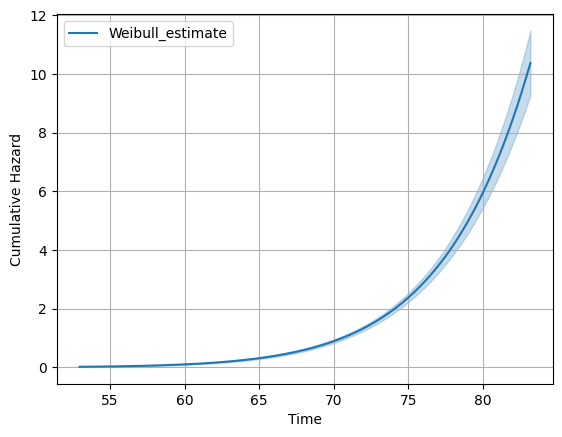

In [5]:
weibull.plot()
plt.xlabel("Time")
plt.ylabel("Cumulative Hazard")
plt.grid(True)
plt.show()

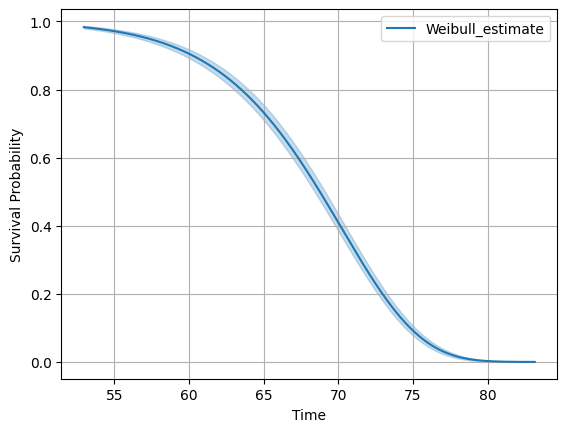

In [6]:
weibull.plot_survival_function()
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()

ρ = Weibull shape parameter <br>
λ = Weibull scale parameter


In [7]:
print("ρ:", weibull.rho_)
print("λ:", weibull.lambda_)

ρ: 14.236532483982558
λ: 70.5645165473171


Rho ≈ 14 indicates a steeply increasing hazard rate, failures become more likely as time progresses. <br>
Lambda ≈ 70 indicates there will 63.2% of failures at ≈ 70. <br>

High rho and lambda indicates that there was good reliability up to t≈70, then it began to rapidly fail.

###  Predict the life span of a new component.

Mathworks predictRUL function returns estRUL, ciRUL, and pdfRUL. 

estRUL - estimates the remaining useful life for a component.<br />
ciRUL - confidence interval associated with the RUL estimation.<br />
pdfRUL - probability density function for the RUL estimation.

##### Probability Density Function

In [8]:
def predict_rul_pdf(model, current_age=0, bin_size=1.0, num_bins=100):
    max_rul = bin_size * num_bins
    rul_times = np.linspace(0, max_rul, num_bins)
    absolute_times = current_age + rul_times

    S_current = float(model.survival_function_at_times(current_age).values[0])

    S_future = model.survival_function_at_times(absolute_times).values.flatten()
    conditional_survival = S_future / S_current
    
    pdf_vals = -np.gradient(conditional_survival, bin_size)
    pdf_vals = np.maximum(pdf_vals, 0)
    pdf_vals /= np.sum(pdf_vals) * bin_size

    return rul_times, pdf_vals 

In [9]:
rul_bins, rul_pdf = predict_rul_pdf(weibull, current_age=0, bin_size=1.0, num_bins=500)

##### Expected RUL

In [10]:
expect_rul = np.sum(rul_bins * rul_pdf)
print(f"Expected RUL: {expect_rul:.2f} hours")

Expected RUL: 68.03 hours


##### Confidence Interval

In [11]:
cdf = np.cumsum(rul_pdf)

low_idx = np.searchsorted(cdf, 0.025)
high_idx = np.searchsorted(cdf, 0.975)

ci_low = rul_bins[low_idx]
ci_high = rul_bins[high_idx]

print(f"95% confidence interval: {ci_low:.2f}, {ci_high:.2f}")


95% confidence interval: 54.11, 77.15


##### Plot functions

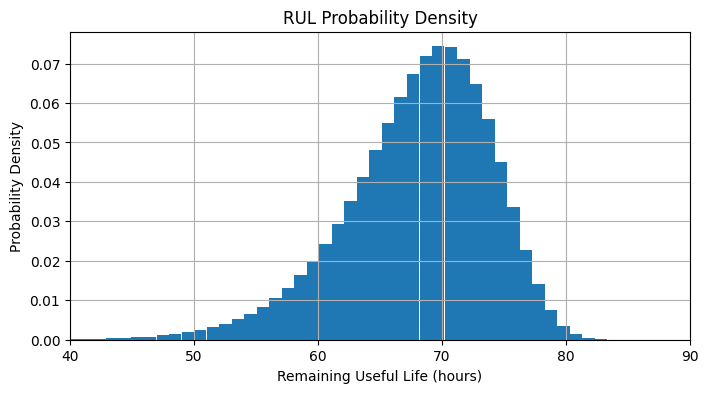

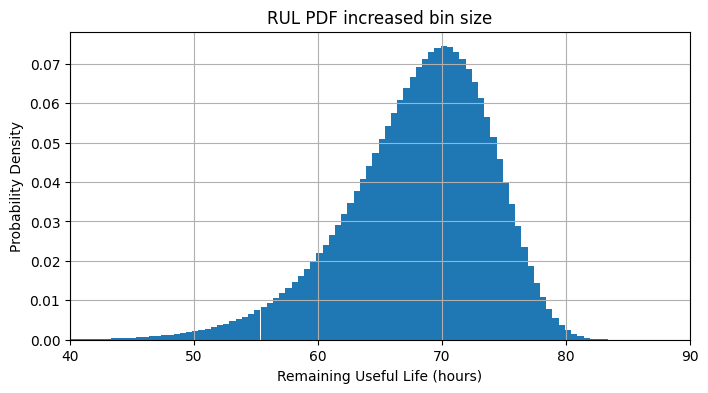

In [12]:
rul_bins, rul_pdf = predict_rul_pdf(weibull, current_age=0, bin_size=1.0, num_bins=100)

plt.figure(figsize=(8, 4))
plt.bar(rul_bins, rul_pdf, width=1.0)
plt.title("RUL Probability Density")
plt.xlabel("Remaining Useful Life (hours)")
plt.ylabel("Probability Density")
plt.xlim(40, 90)
plt.grid(True)
plt.show()


rul_bins2, rul_pdf2 = predict_rul_pdf(weibull, current_age=0, bin_size=0.5, num_bins=500)

plt.figure(figsize=(8, 4))
plt.bar(rul_bins2, rul_pdf2, width=0.5)
plt.title("RUL PDF increased bin size")
plt.xlabel("Remaining Useful Life (hours)")
plt.ylabel("Probability Density")
plt.xlim(40, 90)
plt.grid(True)
plt.show()

Predict the RUL for a component that has been operating for 50 hours.

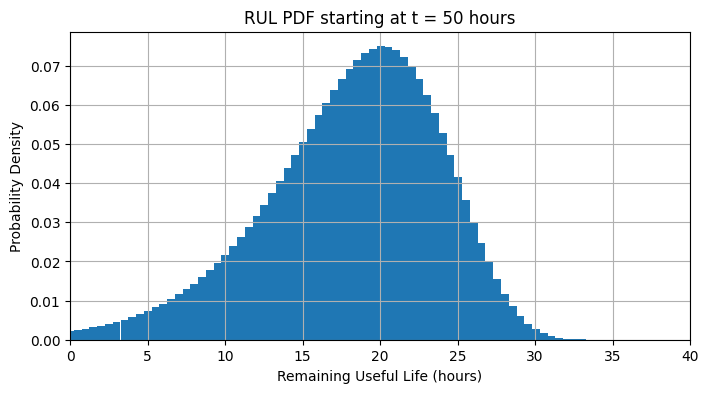

In [13]:
rul_bins2, rul_pdf2 = predict_rul_pdf(weibull, current_age=50, bin_size=0.5, num_bins=500)

plt.figure(figsize=(8, 4))
plt.bar(rul_bins2, rul_pdf2, width=0.5)
plt.title("RUL PDF starting at t = 50 hours")
plt.xlabel("Remaining Useful Life (hours)")
plt.ylabel("Probability Density")
plt.xlim(0, 40)
plt.grid(True)
plt.show()